# Impact of Image Preprocessing on Model Performance

Preprocessing order and techniques significantly impact model performance. We compare two preprocessing implementations:

1. Original Implementation:
   - Random transform (bilinear mirror)
   - Upscale to 384x384 (bicubic)
   - EfficientNetV2 preprocessing

2. Current Implementation:
   - Upscale to 224x224 (bilinear)
   - Sharpen
   - TrivialAugment (controlled randomization)
   - EfficientNetV2 preprocessing

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras as K
import tensorflow as tf

In [53]:
# Load dataset
(X_train, Y_train), (X_test, Y_test) = K.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [54]:
class TrivialAugment:
    def __init__(self):
        self.operations = [
            'rotate', 'translate_x', 'translate_y', 'brightness', 
            'contrast', 'zoom', 'flip'
        ]
        
        self.rotate = K.layers.RandomRotation(20/360)
        self.translate = K.layers.RandomTranslation(0.2, 0.2)
        self.brightness = K.layers.RandomBrightness(0.5)
        self.contrast = K.layers.RandomContrast(0.5)
        self.zoom = K.layers.RandomZoom(0.1)
        self.flip = K.layers.RandomFlip('horizontal')
        
    def __call__(self, image):
        num_ops = np.random.randint(1, 3)
        ops_to_apply = np.random.choice(self.operations, size=num_ops, replace=False)
        
        if isinstance(image, np.ndarray):
            image = K.utils.img_to_array(image)
        
        for op_name in ops_to_apply:
            if op_name == 'rotate':
                image = self.rotate(image, training=True)
            elif op_name == 'translate_x':
                image = self.translate(image, training=True)
            elif op_name == 'translate_y':
                image = self.translate(image, training=True)
            elif op_name == 'brightness':
                image = self.brightness(image, training=True)
            elif op_name == 'contrast':
                image = self.contrast(image, training=True)
            elif op_name == 'zoom':
                image = self.zoom(image, training=True)
            elif op_name == 'flip':
                image = self.flip(image, training=True)
        
        return image

In [55]:
def original_preprocess(image):
    # Random mirror (50% chance)
    if np.random.random() > 0.5:
        image = tf.image.flip_left_right(image)
    
    # Upscale with bicubic
    image = tf.image.resize(image, (384, 384), method='bicubic')
    return K.applications.efficientnet_v2.preprocess_input(image)

def current_preprocess(image):
    # Upscale with bilinear
    image = tf.image.resize(image, (224, 224), method='bilinear')
    
    # Sharpen
    kernel = tf.constant([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])
    kernel = tf.tile(kernel, [1, 1, 3, 1])
    image = tf.cast(image, tf.float32)
    image = tf.nn.depthwise_conv2d(
        tf.expand_dims(image, 0), kernel,
        strides=[1,1,1,1], padding='SAME'
    )[0]
    image = tf.clip_by_value(image, 0, 255)
    
    # TrivialAugment
    augmenter = TrivialAugment()
    image = augmenter(image)
    
    return K.applications.efficientnet_v2.preprocess_input(image)

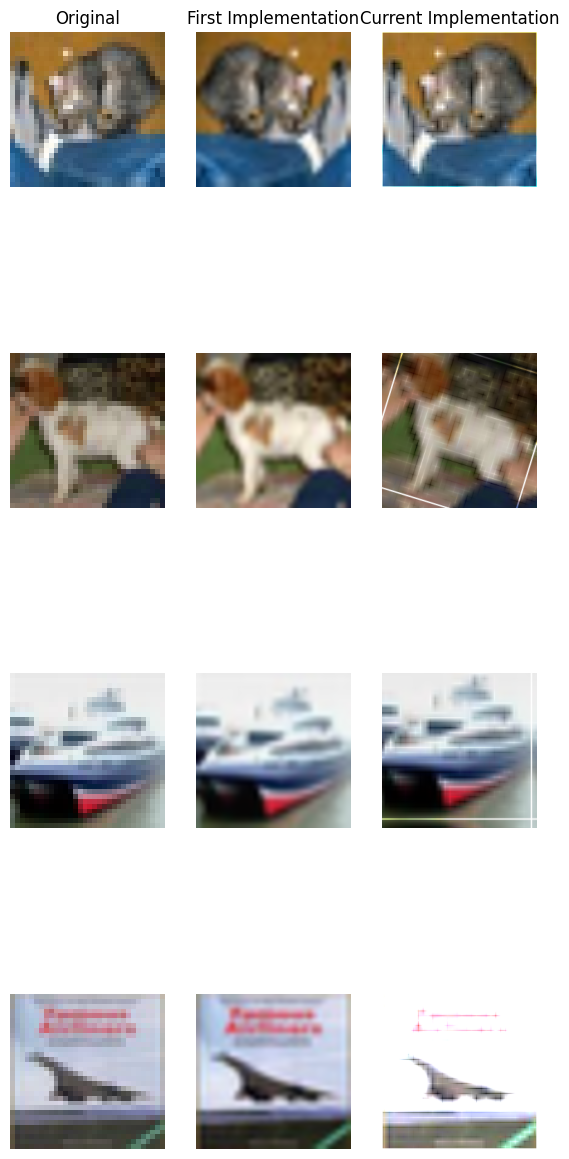

In [56]:
# Plot all four categories
categories = ['cat', 'dog', 'ship', 'airplane']

# Set inches per pixel
ipp = 1/100
padding = 20

# Calculate dimensions
width = (32 + padding + 384 + padding + 224) * ipp
height = (4 * 384 + 3 * padding) * ipp

fig = plt.figure(figsize=(width, height), dpi=100)
gs = fig.add_gridspec(4, 3, hspace=padding*ipp, wspace=padding*ipp)

cols = ['Original', 'First Implementation', 'Current Implementation']

for i, category in enumerate(categories):
   idx = np.where(Y_test == class_names.index(category))[0][0]
   img = X_test[idx]
   
   # Original (32x32)
   ax = fig.add_subplot(gs[i, 0])
   ax.imshow(img.astype(np.uint8), extent=[0, 32, 0, 32])
   if i == 0:
       ax.set_title(cols[0])
   ax.set_ylabel(category)
   ax.axis('off')
   
   # First implementation (384x384)
   ax = fig.add_subplot(gs[i, 1])
   proc_img1 = original_preprocess(img)
   proc_img1 = (proc_img1 - tf.reduce_min(proc_img1)) / (tf.reduce_max(proc_img1) - tf.reduce_min(proc_img1))
   ax.imshow(proc_img1, extent=[0, 384, 0, 384])
   if i == 0:
       ax.set_title(cols[1])
   ax.axis('off')
   
   # Current implementation (224x224)
   ax = fig.add_subplot(gs[i, 2])
   proc_img2 = current_preprocess(img)
   proc_img2 = (proc_img2 - tf.reduce_min(proc_img2)) / (tf.reduce_max(proc_img2) - tf.reduce_min(proc_img2))
   ax.imshow(proc_img2, extent=[0, 224, 0, 224])
   if i == 0:
       ax.set_title(cols[2])
   ax.axis('off')

plt.savefig('preprocessing_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

## Key Observations

1. First Implementation:
   - Higher resolution but potential interpolation artifacts
   - Limited augmentation variety
   - High memory usage due to large image size

2. Current Implementation:
   - More controlled resolution with bilinear interpolation
   - Enhanced detail preservation through sharpening
   - Diverse but constrained augmentations
   - Lower memory footprint

[TODO: Add model performance metrics with each preprocessing scheme]